# Surrogate modeling or functional approximation for the forward model 
    - Feed forward neural network, also known as a multilayer perceptron (MLP)
## Develop a neural network model that will act as a lookup table and work with IMP
* Generate ground truth dataset to train the NN on 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import h5py
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize_scalar
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter

### MCMC code to generate ground truth data points
* Points $\vec{p_i}$ and $\vec{p_j}$ picked at random
* Spheres of radius $\sigma_i$ and $\sigma_j$ around the two points
* Volumes of the spheres as $v_i = \frac{4}{3}\pi \left(\sigma_i\right)^3$ and $v_j = \frac{4}{3}\pi \left(\sigma_j\right)^3$
* Check distance $d_{ij} = |\vec{p_i} -\vec{p_j}|$
    - if $d_{ij} < \sigma_i + \sigma_j$
        - $xlvol = \frac{4}{3}\pi \left(\frac{L}{2}\right)^3$
        - $vol_i = min(v_i, xlvol)$
        - $vol_j = min(v_j, xlvol)$

## Analytical model is not what we shall implement, but a no brainer MCMC code, that will simply pick random points and compute the distances between them, if $d_{ij} < L$ then, store it as success, run the same for some million times, get a converged probability

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

class CrosslinkProbabilityEstimator:
    '''
    Monte Carlo estimator for crosslink probability between two points.
    Generates training data, computes probabilities, and visualizes configurations.
    
    Parameters:
    -----------
    L : float
        Crosslinker length threshold (default: 21.0 Angstroms)
    '''
    
    def __init__(self, L=21.0):
        self.L = L
        self.configurations = []
        self.results = []
        
    def _pick_points(self, p1, p2, sigma1, sigma2):
        '''
        Sample one point from each uncertainty sphere and check if crosslink is possible.
        
        Parameters:
        -----------
        p1 : np.ndarray
            Center position of first point (shape: (3,))
        p2 : np.ndarray
            Center position of second point (shape: (3,))
        sigma1 : float
            Positional uncertainty (radius) for first point
        sigma2 : float
            Positional uncertainty (radius) for second point
            
        Returns:
        --------
        bool
            True if distance between sampled points < L, False otherwise
        '''
        q1 = p1 + np.random.normal(0, sigma1, size=p1.shape)
        q2 = p2 + np.random.normal(0, sigma2, size=p2.shape)
        d = np.linalg.norm(q1 - q2)
        return d < self.L
    
    def estimate_probability(self, p1, p2, sigma1, sigma2, N=50000):
        '''
        Estimate crosslink probability using Monte Carlo sampling.
        
        Parameters:
        -----------
        p1 : np.ndarray
            Center position of first point (shape: (3,))
        p2 : np.ndarray
            Center position of second point (shape: (3,))
        sigma1 : float
            Positional uncertainty (radius) for first point
        sigma2 : float
            Positional uncertainty (radius) for second point
        N : int
            Number of Monte Carlo trials
            
        Returns:
        --------
        float
            Estimated probability of crosslinking (between 0 and 1)
        '''
        success_count = 0
        for _ in range(N):
            if self._pick_points(p1, p2, sigma1, sigma2):
                success_count += 1
        
        return success_count / N
    
    def generate_configurations(self, num_configs, 
                               position_range=(-50, 50),
                               sigma_range=(1, 20),
                               N_trials=50000,
                               verbose=True):
        '''
        Generate random configurations and compute crosslink probabilities.
        
        Parameters:
        -----------
        num_configs : int
            Number of configurations to generate
        position_range : tuple
            Range for random point positions (min, max)
        sigma_range : tuple
            Range for random sigma values (min, max)
        N_trials : int
            Number of Monte Carlo trials per configuration
        verbose : bool
            Whether to print progress
            
        Returns:
        --------
        None (stores results in self.configurations and self.results)
        '''
        self.configurations = []
        self.results = []
        
        for i in range(num_configs):
            # Generate random configuration
            p1 = np.random.uniform(position_range[0], position_range[1], size=(3,))
            p2 = np.random.uniform(position_range[0], position_range[1], size=(3,))
            sigma1 = np.random.uniform(sigma_range[0], sigma_range[1])
            sigma2 = np.random.uniform(sigma_range[0], sigma_range[1])
            
            # Compute distance between centers
            d = np.linalg.norm(p1 - p2)
            
            # Estimate probability
            prob = self.estimate_probability(p1, p2, sigma1, sigma2, N=N_trials)
            
            # Store configuration
            config = {
                'p1': p1,
                'p2': p2,
                'sigma1': sigma1,
                'sigma2': sigma2,
                'd': d,
                'L': self.L,
                'probability': prob
            }
            self.configurations.append(config)
            
            # Store result for training data (invariant features)
            self.results.append([d, sigma1, sigma2, self.L, prob])
            
            if verbose and (i + 1) % max(1, num_configs // 10) == 0:
                print(f"Generated {i + 1}/{num_configs} configurations...")
        
        if verbose:
            print(f"Completed! Generated {num_configs} configurations.")
    
    def save_training_data(self, filename='surrogate_model_data', format='npz'):
        '''
        Save generated training data to disk.
        
        Parameters:
        -----------
        filename : str
            Base filename (without extension)
        format : str
            'npz' for NumPy compressed or 'hdf5' for HDF5 format
        '''
        if not self.results:
            raise ValueError("No data to save. Run generate_configurations() first.")
        
        results_array = np.array(self.results)
        X_data = results_array[:, :-1]  # Features: [d, sigma1, sigma2, L]
        y_data = results_array[:, -1:]  # Target: [probability]
        
        if format == 'npz':
            np.savez_compressed(f'{filename}.npz', X=X_data, y=y_data)
            print(f"Saved training data to {filename}.npz")
        elif format == 'hdf5':
            with h5py.File(f'{filename}.h5', 'w') as f:
                f.create_dataset('X', data=X_data, compression='gzip')
                f.create_dataset('y', data=y_data, compression='gzip')
            print(f"Saved training data to {filename}.h5")
        else:
            raise ValueError("Format must be 'npz' or 'hdf5'")
    
    def prepare_training_data(self, test_size=0.2, save_scaler=True):
        '''
        Prepare and normalize training data for neural network.
        
        Parameters:
        -----------
        test_size : float
            Fraction of data to use for validation
        save_scaler : bool
            Whether to save the fitted scaler to disk
            
        Returns:
        --------
        tuple
            (X_train_scaled, X_val_scaled, y_train, y_val, scaler)
        '''
        if not self.results:
            raise ValueError("No data to prepare. Run generate_configurations() first.")
        
        results_array = np.array(self.results)
        X_all = results_array[:, :-1]  # Features: [d, sigma1, sigma2, L]
        y_all = results_array[:, -1:]  # Target: [probability]
        
        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X_all, y_all, test_size=test_size, random_state=42
        )
        
        # Fit scaler on training data only
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        if save_scaler:
            with open('data_scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            print("Saved scaler to data_scaler.pkl")
        
        print(f"Training set: {X_train_scaled.shape[0]} samples")
        print(f"Validation set: {X_val_scaled.shape[0]} samples")
        
        return X_train_scaled, X_val_scaled, y_train, y_val, scaler
    
    def visualize_configurations(self, num_visualize=None, output_dir='output_figures'):
        '''
        Visualize generated configurations as 3D sphere plots.
        
        Parameters:
        -----------
        num_visualize : int or None
            Number of configurations to visualize (None = visualize all)
        output_dir : str
            Directory to save PDF file
        '''
        if not self.configurations:
            raise ValueError("No configurations to visualize. Run generate_configurations() first.")
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Determine how many to visualize
        if num_visualize is None:
            num_visualize = len(self.configurations)
        else:
            num_visualize = min(num_visualize, len(self.configurations))
        
        pdf_path = os.path.join(output_dir, 'configurations_visualization.pdf')
        
        with PdfPages(pdf_path) as pdf:
            for i in range(num_visualize):
                config = self.configurations[i]
                
                fig = plt.figure(figsize=(12, 10))
                ax = fig.add_subplot(111, projection='3d')
                
                p1 = config['p1']
                p2 = config['p2']
                sigma1 = config['sigma1']
                sigma2 = config['sigma2']
                d = config['d']
                prob = config['probability']
                
                # Draw spheres
                u = np.linspace(0, 2 * np.pi, 50)
                v = np.linspace(0, np.pi, 50)
                
                # Sphere 1
                x1 = p1[0] + sigma1 * np.outer(np.cos(u), np.sin(v))
                y1 = p1[1] + sigma1 * np.outer(np.sin(u), np.sin(v))
                z1 = p1[2] + sigma1 * np.outer(np.ones(np.size(u)), np.cos(v))
                ax.plot_surface(x1, y1, z1, alpha=0.3, color='blue', label='Sphere 1')
                
                # Sphere 2
                x2 = p2[0] + sigma2 * np.outer(np.cos(u), np.sin(v))
                y2 = p2[1] + sigma2 * np.outer(np.sin(u), np.sin(v))
                z2 = p2[2] + sigma2 * np.outer(np.ones(np.size(u)), np.cos(v))
                ax.plot_surface(x2, y2, z2, alpha=0.3, color='red', label='Sphere 2')
                
                # Plot centers
                ax.scatter(*p1, color='blue', s=100, marker='o', label='Center 1')
                ax.scatter(*p2, color='red', s=100, marker='o', label='Center 2')
                
                # Draw line between centers
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                       'k--', linewidth=2, label=f'd = {d:.2f}Å')
                
                # Annotations
                ax.text(p1[0], p1[1], p1[2] + sigma1 + 5, 
                       f'σ₁ = {sigma1:.2f}Å\np₁ = ({p1[0]:.1f}, {p1[1]:.1f}, {p1[2]:.1f})',
                       fontsize=9, ha='center')
                ax.text(p2[0], p2[1], p2[2] + sigma2 + 5, 
                       f'σ₂ = {sigma2:.2f}Å\np₂ = ({p2[0]:.1f}, {p2[1]:.1f}, {p2[2]:.1f})',
                       fontsize=9, ha='center')
                
                # Set labels and title
                ax.set_xlabel('X (Å)')
                ax.set_ylabel('Y (Å)')
                ax.set_zlabel('Z (Å)')
                ax.set_title(f'Configuration {i + 1}\n'
                           f'Crosslinker Length L = {self.L:.1f}Å\n'
                           f'Distance d = {d:.2f}Å\n'
                           f'Crosslink Probability = {prob:.4f}',
                           fontsize=12, fontweight='bold')
                
                ax.legend(loc='upper right')
                
                # Equal aspect ratio
                max_range = np.array([
                    max(abs(p1[0]) + sigma1, abs(p2[0]) + sigma2),
                    max(abs(p1[1]) + sigma1, abs(p2[1]) + sigma2),
                    max(abs(p1[2]) + sigma1, abs(p2[2]) + sigma2)
                ]).max()
                
                mid_x = (p1[0] + p2[0]) / 2
                mid_y = (p1[1] + p2[1]) / 2
                mid_z = (p1[2] + p2[2]) / 2
                
                ax.set_xlim(mid_x - max_range * 0.6, mid_x + max_range * 0.6)
                ax.set_ylim(mid_y - max_range * 0.6, mid_y + max_range * 0.6)
                ax.set_zlim(mid_z - max_range * 0.6, mid_z + max_range * 0.6)
                
                plt.tight_layout()
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)
                
                if (i + 1) % 10 == 0:
                    print(f"Visualized {i + 1}/{num_visualize} configurations...")
        
        print(f"Saved visualization to {pdf_path}")

# Example usage
if __name__ == "__main__":
    # Create estimator
    estimator = CrosslinkProbabilityEstimator(L=21.0)
    
    # Generate configurations
    estimator.generate_configurations(num_configs=1000, N_trials=50000)
    
    # Save training data
    estimator.save_training_data(filename='surrogate_model_data', format='hdf5')
    
    # Prepare for training
    X_train, X_val, y_train, y_val, scaler = estimator.prepare_training_data()
    
    # Visualize first 20 configurations
    estimator.visualize_configurations(num_visualize=20)

Generated 100/1000 configurations...
Generated 200/1000 configurations...
Generated 300/1000 configurations...
Generated 400/1000 configurations...
Generated 500/1000 configurations...
Generated 600/1000 configurations...
Generated 700/1000 configurations...
Generated 800/1000 configurations...
Generated 900/1000 configurations...
Generated 1000/1000 configurations...
Completed! Generated 1000 configurations.
Saved training data to surrogate_model_data.h5
Saved scaler to data_scaler.pkl
Training set: 800 samples
Validation set: 200 samples


/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/1555028032.py:314: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  pdf.savefig(fig, bbox_inches='tight')
/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/1555028032.py:314: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  pdf.savefig(fig, bbox_inches='tight')


Visualized 10/20 configurations...
Visualized 20/20 configurations...
Saved visualization to output_figures/configurations_visualization.pdf


# Neural Network Surrogate Model for Crosslink Probability

## Overview

This notebook implements a **feed-forward neural network** (also called a **multilayer perceptron** or **MLP**) to predict crosslink probabilities. The network acts as a **surrogate model** - a fast approximation of the expensive Monte Carlo simulation.

### What is a Surrogate Model?

A **surrogate model** is a simplified approximation of a complex, computationally expensive function. Instead of running 100,000 Monte Carlo trials every time we need a probability estimate, we:

1. **Pre-compute** ground truth data using Monte Carlo (already done in previous step)
2. **Train** a neural network to learn the relationship between inputs $(d, \sigma_1, \sigma_2, L)$ and output (probability)
3. **Use** the trained network for fast predictions (milliseconds instead of seconds)

### Problem Formulation

**Input Features** ($\mathbf{x}$):
- $d$: Distance between particle centers (Å)
- $\sigma_1$: Positional uncertainty of particle 1 (Å)
- $\sigma_2$: Positional uncertainty of particle 2 (Å)
- $L$: Crosslinker maximum length (Å)

**Output** ($y$):
- $P(\text{crosslink})$: Probability that particles can form a crosslink (value between 0 and 1)

**Goal**: Learn a function $f_\theta: \mathbb{R}^4 \rightarrow [0, 1]$ such that:

$$
\hat{y} = f_\theta(d, \sigma_1, \sigma_2, L) \approx P(\text{crosslink})
$$

where $\theta$ represents the neural network weights (parameters we learn during training).

---

## Mathematical Background

### Feed-Forward Neural Network Architecture

A feed-forward neural network transforms input $\mathbf{x}$ through multiple layers:

$$
\begin{align}
\mathbf{h}_1 &= \sigma_1(W_1 \mathbf{x} + \mathbf{b}_1) \quad \text{(First hidden layer)} \\
\mathbf{h}_2 &= \sigma_2(W_2 \mathbf{h}_1 + \mathbf{b}_2) \quad \text{(Second hidden layer)} \\
\hat{y} &= \sigma_{\text{out}}(W_{\text{out}} \mathbf{h}_2 + \mathbf{b}_{\text{out}}) \quad \text{(Output layer)}
\end{align}
$$

where:
- $W_i$: Weight matrices (learned parameters)
- $\mathbf{b}_i$: Bias vectors (learned parameters)
- $\sigma_i$: Activation functions (non-linear transformations)

### Activation Functions

**ReLU (Rectified Linear Unit)** for hidden layers:
$$
\text{ReLU}(x) = \max(0, x)
$$

**Sigmoid** for output layer (ensures output is in $[0, 1]$):
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

### Loss Function: Mean Squared Error (MSE)

We use **Mean Squared Error** to measure how far our predictions are from the ground truth:

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \hat{y}_i \right)^2
$$

where:
- $N$: Number of training samples
- $y_i$: True probability (from Monte Carlo)
- $\hat{y}_i$: Predicted probability (from neural network)

**Why MSE?**
- Simple and differentiable
- Penalizes large errors more than small ones (quadratic penalty)
- Well-suited for regression problems (predicting continuous values)

### Training Algorithm: Stochastic Gradient Descent (SGD)

The network learns by iteratively updating weights to minimize the loss:

$$
\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}(\theta_t)
$$

where:
- $\eta$: Learning rate (step size)
- $\nabla_\theta \mathcal{L}$: Gradient of loss with respect to parameters

We use **Adam optimizer**, an advanced variant that:
- Adapts learning rate for each parameter
- Uses momentum (exponential moving average of gradients)
- More stable and faster convergence than vanilla SGD

---

## Key Machine Learning Concepts

### 1. Train-Test Split

We divide data into:
- **Training Set (80%)**: Used to learn network parameters
- **Validation/Test Set (20%)**: Used to evaluate generalization

**Why?** To detect **overfitting** - when the model memorizes training data but fails on new data.

### 2. Feature Normalization (Standardization)

We transform features to have zero mean and unit variance:

$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation.

**Why?**
- Neural networks train faster with normalized inputs
- Prevents features with large values from dominating
- Improves numerical stability

**Important:** We fit the scaler on training data only, then apply the same transformation to validation data (to avoid data leakage).

### 3. Batching and Epochs

- **Batch**: Subset of training data processed together (e.g., 32 samples)
- **Epoch**: One complete pass through the entire training dataset

**Why batching?**
- Memory efficiency (can't fit all data in GPU memory)
- Faster computation (parallelization)
- Regularization effect (noisy gradient estimates prevent overfitting)

### 4. Evaluation Metrics

Beyond MSE, we track:

**Mean Absolute Error (MAE)**:
$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
$$

**$R^2$ Score (Coefficient of Determination)**:
$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

where $\bar{y}$ is the mean of true values. $R^2 = 1$ means perfect predictions.

---

## Implementation Steps

1. **Load Data**: Read HDF5 file containing features and targets
2. **Exploratory Data Analysis**: Visualize distributions and correlations
3. **Data Preprocessing**: Normalize features and split into train/test
4. **Define Model Architecture**: Create neural network structure
5. **Training Loop**: Optimize weights using backpropagation
6. **Evaluation**: Assess performance on held-out test set
7. **Visualization**: Plot predictions vs. ground truth
8. **Save Model**: Export trained network for later use

Let's begin!

In [17]:
# ===================================================================
# PART 1: IMPORTS AND SETUP
# ===================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import h5py
import pickle

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Using device: cpu


In [18]:
# ===================================================================
# PART 2: LOAD DATA FROM HDF5 FILE
# ===================================================================

def load_data_from_hdf5(filepath='surrogate_model_data.h5'):
    """
    Load training data from HDF5 file.
    
    The HDF5 file contains:
    - 'X': Feature matrix [N x 4] where columns are [d, sigma1, sigma2, L]
    - 'y': Target vector [N x 1] containing crosslink probabilities
    
    Parameters:
    -----------
    filepath : str
        Path to HDF5 file
        
    Returns:
    --------
    X : np.ndarray
        Feature matrix (shape: [N, 4])
    y : np.ndarray
        Target vector (shape: [N, 1])
    """
    print(f"Loading data from {filepath}...")
    
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}")
    
    with h5py.File(filepath, 'r') as f:
        # Read datasets
        X = f['X'][:]
        y = f['y'][:]
        
        print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features")
        print(f"Feature matrix shape: {X.shape}")
        print(f"Target vector shape: {y.shape}")
        
    return X, y

# Load the data
X_raw, y_raw = load_data_from_hdf5('surrogate_model_data.h5')

# Feature names for reference
feature_names = ['distance (d)', 'sigma1 (σ₁)', 'sigma2 (σ₂)', 'linker_length (L)']
print(f"\nFeatures: {feature_names}")

Loading data from surrogate_model_data.h5...
Loaded 1000 samples with 4 features
Feature matrix shape: (1000, 4)
Target vector shape: (1000, 1)

Features: ['distance (d)', 'sigma1 (σ₁)', 'sigma2 (σ₂)', 'linker_length (L)']


/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/673703684.py:57: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/673703684.py:57: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


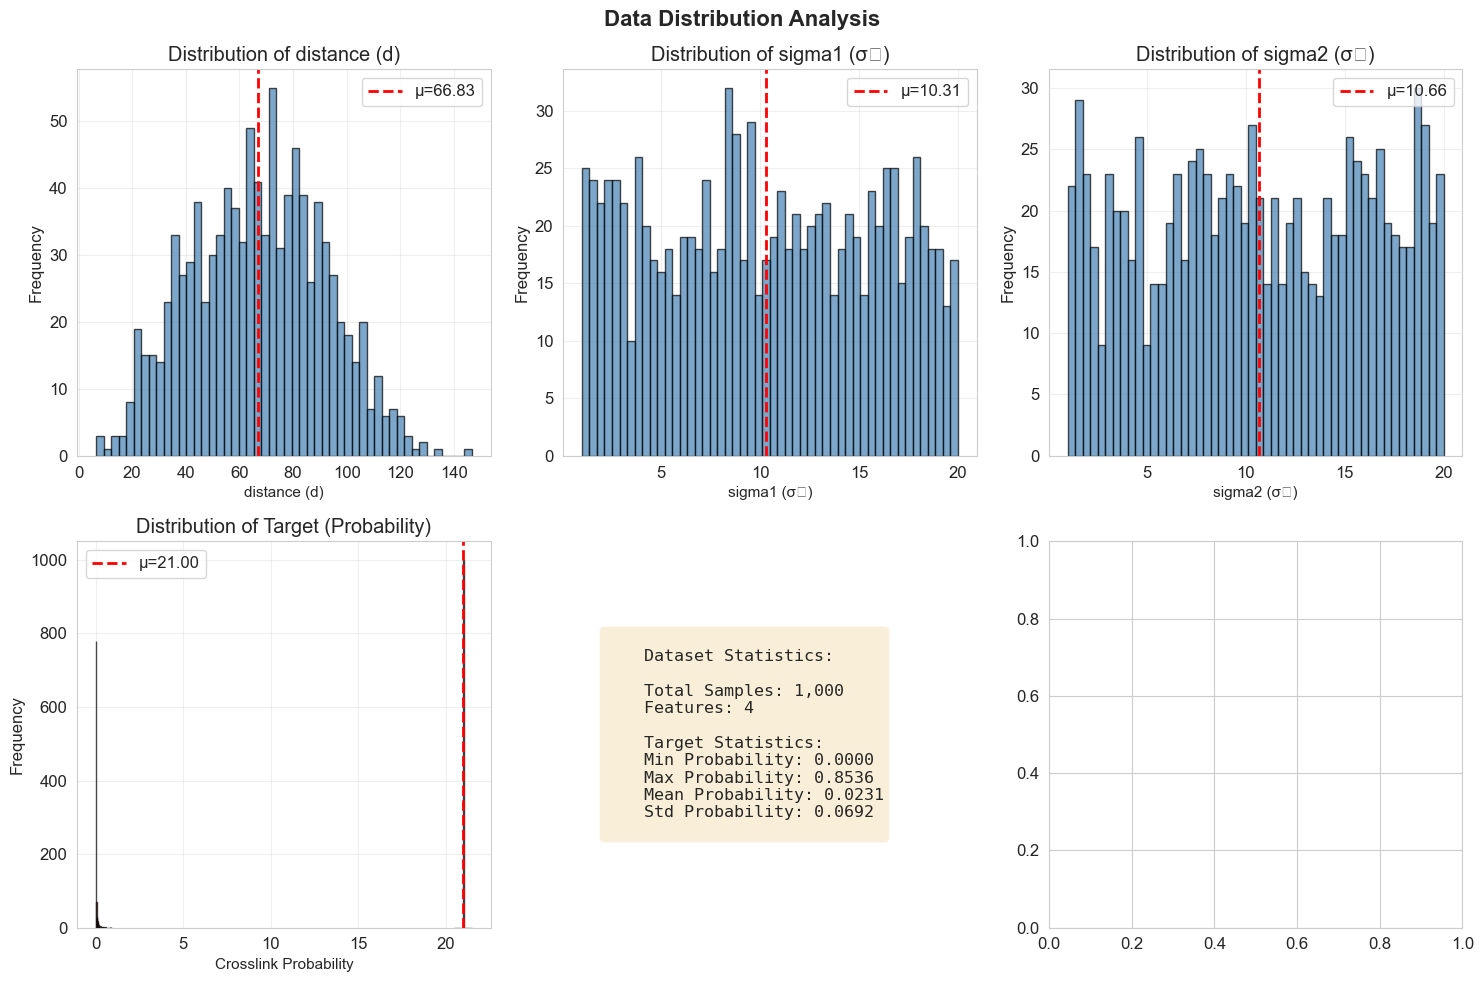

/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/imptorch-latest-cpu/lib/python3.12/site-package

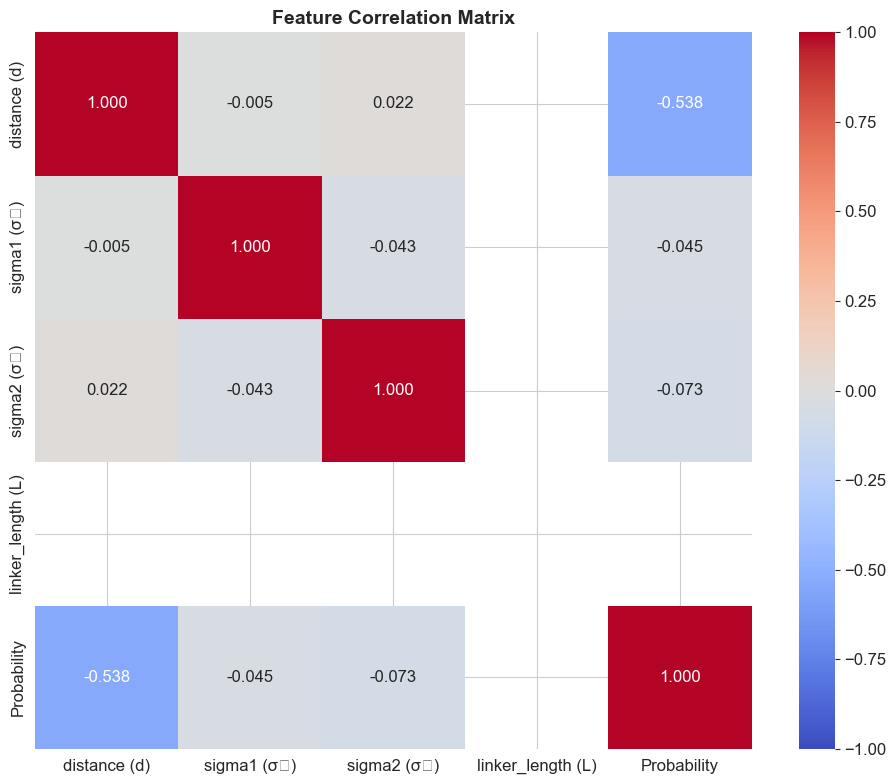

In [19]:
# ===================================================================
# PART 3: EXPLORATORY DATA ANALYSIS (EDA)
# ===================================================================

def visualize_data_distribution(X, y, feature_names):
    """
    Visualize distributions of features and target variable.
    
    This helps us understand:
    - Range of values for each feature
    - Whether data is balanced or skewed
    - Potential outliers
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Data Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Plot distributions for each feature
    for idx, (feature_name, ax) in enumerate(zip(feature_names, axes.flat[:4])):
        ax.hist(X[:, idx], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_xlabel(feature_name, fontsize=11)
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {feature_name}')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        mean_val = np.mean(X[:, idx])
        std_val = np.std(X[:, idx])
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                   label=f'μ={mean_val:.2f}')
        ax.legend()
    
    # Plot target distribution
    axes[1, 0].hist(y, bins=50, alpha=0.7, color='coral', edgecolor='black')
    axes[1, 0].set_xlabel('Crosslink Probability')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Target (Probability)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Statistical summary
    axes[1, 1].axis('off')
    summary_text = f"""
    Dataset Statistics:
    
    Total Samples: {X.shape[0]:,}
    Features: {X.shape[1]}
    
    Target Statistics:
    Min Probability: {y.min():.4f}
    Max Probability: {y.max():.4f}
    Mean Probability: {y.mean():.4f}
    Std Probability: {y.std():.4f}
    """
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, 
                    verticalalignment='center', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

# Visualize data
fig_dist = visualize_data_distribution(X_raw, y_raw, feature_names)
plt.show()

# Correlation analysis
def plot_correlation_matrix(X, y, feature_names):
    """
    Visualize correlations between features and target.
    
    High correlation between features might indicate redundancy.
    Correlation with target shows predictive power.
    """
    # Combine features and target
    data_combined = np.hstack([X, y])
    labels = feature_names + ['Probability']
    
    # Compute correlation matrix
    corr_matrix = np.corrcoef(data_combined.T)
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                xticklabels=labels, yticklabels=labels, 
                center=0, vmin=-1, vmax=1, square=True, ax=ax)
    ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig_corr = plot_correlation_matrix(X_raw, y_raw, feature_names)
plt.show()

In [20]:
# ===================================================================
# PART 4: DATA PREPROCESSING AND SPLITTING
# ===================================================================

def prepare_data_for_training(X, y, test_size=0.2, random_state=42):
    """
    Prepare data for neural network training.
    
    Steps:
    1. Split into train/test sets (80/20 split)
    2. Normalize features using StandardScaler
    3. Convert to PyTorch tensors
    
    Why normalize?
    - Neural networks are sensitive to feature scales
    - Features with large values can dominate gradient updates
    - Normalization: x_scaled = (x - mean) / std
    
    Important: We fit the scaler ONLY on training data to avoid data leakage
    (the test set should remain "unseen" during preprocessing)
    
    Parameters:
    -----------
    X : np.ndarray
        Feature matrix
    y : np.ndarray
        Target vector
    test_size : float
        Fraction of data for testing (default: 0.2 = 20%)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_train_scaled : torch.Tensor
        Normalized training features
    X_test_scaled : torch.Tensor
        Normalized test features
    y_train : torch.Tensor
        Training targets
    y_test : torch.Tensor
        Test targets
    scaler : StandardScaler
        Fitted scaler (needed for inference on new data)
    """
    print("\n" + "="*70)
    print("DATA PREPROCESSING AND SPLITTING")
    print("="*70)
    
    # Step 1: Split data into train and test sets
    # stratify=None because we have continuous target (not classification)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"\nData Split:")
    print(f"  Training samples: {X_train.shape[0]} ({100*(1-test_size):.0f}%)")
    print(f"  Test samples: {X_test.shape[0]} ({100*test_size:.0f}%)")
    
    # Step 2: Feature normalization
    # Fit scaler on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Apply same transformation to test data (using training statistics)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\nFeature Scaling Statistics (from training data):")
    for i, feature_name in enumerate(feature_names):
        print(f"  {feature_name}:")
        print(f"    Mean: {scaler.mean_[i]:.4f}")
        print(f"    Std:  {scaler.scale_[i]:.4f}")
    
    # Step 3: Convert to PyTorch tensors
    # dtype=torch.float32 is standard for neural networks
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    print(f"\nTensor Shapes:")
    print(f"  X_train: {X_train_tensor.shape}")
    print(f"  y_train: {y_train_tensor.shape}")
    print(f"  X_test:  {X_test_tensor.shape}")
    print(f"  y_test:  {y_test_tensor.shape}")
    
    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, scaler

# Prepare data
X_train, X_test, y_train, y_test, scaler = prepare_data_for_training(
    X_raw, y_raw, test_size=0.2
)

# Save scaler for later use
with open('nn_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nSaved scaler to nn_scaler.pkl")


DATA PREPROCESSING AND SPLITTING

Data Split:
  Training samples: 800 (80%)
  Test samples: 200 (20%)

Feature Scaling Statistics (from training data):
  distance (d):
    Mean: 67.0210
    Std:  24.7909
  sigma1 (σ₁):
    Mean: 10.2687
    Std:  5.4889
  sigma2 (σ₂):
    Mean: 10.7528
    Std:  5.5999
  linker_length (L):
    Mean: 21.0000
    Std:  1.0000

Tensor Shapes:
  X_train: torch.Size([800, 4])
  y_train: torch.Size([800, 1])
  X_test:  torch.Size([200, 4])
  y_test:  torch.Size([200, 1])

Saved scaler to nn_scaler.pkl


In [21]:
# ===================================================================
# PART 5: CREATE DATALOADERS FOR EFFICIENT TRAINING
# ===================================================================

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):
    """
    Create PyTorch DataLoaders for batch training.
    
    What is a DataLoader?
    - Automatically batches data (groups samples together)
    - Shuffles training data each epoch (prevents overfitting to order)
    - Enables parallel data loading (faster training)
    
    What is batch_size?
    - Number of samples processed together in one forward/backward pass
    - Trade-off: Larger batches = faster but more memory
    - Common values: 16, 32, 64, 128
    
    Parameters:
    -----------
    X_train, y_train : torch.Tensor
        Training data
    X_test, y_test : torch.Tensor
        Test data
    batch_size : int
        Number of samples per batch
        
    Returns:
    --------
    train_loader : DataLoader
        Iterator for training batches
    test_loader : DataLoader
        Iterator for test batches
    """
    # Create TensorDataset (pairs inputs with targets)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # Shuffle training data each epoch
        num_workers=0  # 0 for compatibility (use >0 for multi-core loading)
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle test data
        num_workers=0
    )
    
    print(f"\nCreated DataLoaders:")
    print(f"  Batch size: {batch_size}")
    print(f"  Training batches per epoch: {len(train_loader)}")
    print(f"  Test batches: {len(test_loader)}")
    
    return train_loader, test_loader

# Create dataloaders
BATCH_SIZE = 32
train_loader, test_loader = create_dataloaders(
    X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE
)


Created DataLoaders:
  Batch size: 32
  Training batches per epoch: 25
  Test batches: 7


In [22]:
# ===================================================================
# PART 6: DEFINE NEURAL NETWORK ARCHITECTURE
# ===================================================================

class CrosslinkProbabilityNN(nn.Module):
    """
    Feed-Forward Neural Network for Crosslink Probability Prediction.
    
    Architecture:
    ------------
    Input Layer:  4 features [d, σ₁, σ₂, L]
    Hidden Layer 1: 64 neurons with ReLU activation
    Hidden Layer 2: 32 neurons with ReLU activation
    Hidden Layer 3: 16 neurons with ReLU activation
    Output Layer: 1 neuron with Sigmoid activation (probability ∈ [0, 1])
    
    Mathematical Flow:
    -----------------
    h₁ = ReLU(W₁·x + b₁)
    h₂ = ReLU(W₂·h₁ + b₂)
    h₃ = ReLU(W₃·h₂ + b₃)
    ŷ  = Sigmoid(W_out·h₃ + b_out)
    
    Activation Functions:
    --------------------
    - ReLU: max(0, x) - introduces non-linearity, easy to compute
    - Sigmoid: 1/(1+e⁻ˣ) - squashes output to [0, 1] for probability
    
    Why this architecture?
    ---------------------
    - 3 hidden layers: Deep enough to learn complex patterns
    - Decreasing neurons (64→32→16): Funnel information toward output
    - Not too deep: Avoids vanishing gradients and overfitting
    """
    
    def __init__(self, input_size=4, hidden_sizes=[64, 32, 16]):
        """
        Initialize network layers.
        
        Parameters:
        -----------
        input_size : int
            Number of input features (default: 4)
        hidden_sizes : list
            Neurons in each hidden layer (default: [64, 32, 16])
        """
        super(CrosslinkProbabilityNN, self).__init__()
        
        # Layer 1: Input → First Hidden
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        
        # Layer 2: First Hidden → Second Hidden
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        
        # Layer 3: Second Hidden → Third Hidden
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        
        # Output Layer: Third Hidden → Output
        self.fc_out = nn.Linear(hidden_sizes[2], 1)
        self.sigmoid = nn.Sigmoid()
        
        # Store architecture info
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        
    def forward(self, x):
        """
        Forward pass: compute predictions from inputs.
        
        This method defines how data flows through the network.
        Called automatically when you do: model(x)
        
        Parameters:
        -----------
        x : torch.Tensor
            Input features (shape: [batch_size, 4])
            
        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities (shape: [batch_size, 1])
        """
        # Pass through layers sequentially
        x = self.fc1(x)      # Linear transformation
        x = self.relu1(x)    # Non-linear activation
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc_out(x)
        out = self.sigmoid(x)  # Squash to [0, 1]
        
        return out
    
    def count_parameters(self):
        """Count total trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Initialize model
model = CrosslinkProbabilityNN(input_size=4, hidden_sizes=[64, 32, 16])

# Move model to GPU if available
model = model.to(device)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(model)
print(f"\nTotal trainable parameters: {model.count_parameters():,}")
print(f"Model device: {next(model.parameters()).device}")


MODEL ARCHITECTURE
CrosslinkProbabilityNN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total trainable parameters: 2,945
Model device: cpu


In [23]:
# ===================================================================
# PART 7: DEFINE LOSS FUNCTION AND OPTIMIZER
# ===================================================================

"""
LOSS FUNCTION: Mean Squared Error (MSE)
========================================

Formula: MSE = (1/N) Σᵢ (yᵢ - ŷᵢ)²

Where:
- yᵢ: True probability (from Monte Carlo)
- ŷᵢ: Predicted probability (from neural network)
- N: Number of samples in batch

Why MSE for this problem?
- Regression task (predicting continuous values 0-1)
- Penalizes large errors more than small ones (quadratic)
- Differentiable (required for backpropagation)
- Standard choice for probability estimation

Alternative loss functions:
- MAE (Mean Absolute Error): Less sensitive to outliers
- BCE (Binary Cross-Entropy): Common for probabilities, but assumes binary outcomes
- Huber Loss: Robust to outliers, combines MSE and MAE
"""

criterion = nn.MSELoss()
print("Loss Function: Mean Squared Error (MSE)")

"""
OPTIMIZER: Adam (Adaptive Moment Estimation)
=============================================

Adam is an advanced optimization algorithm that adapts learning rates.

Key Features:
1. Momentum: Uses exponential moving average of gradients
   - Helps escape local minima
   - Smooths out noisy gradients

2. Adaptive Learning Rates: Different learning rate for each parameter
   - Parameters with large gradients get smaller updates
   - Parameters with small gradients get larger updates

3. Bias Correction: Corrects initialization bias in early iterations

Update Rule (simplified):
θₜ₊₁ = θₜ - η · mₜ / (√vₜ + ε)

Where:
- θ: Parameters (weights and biases)
- η: Learning rate (step size)
- mₜ: First moment estimate (mean of gradients)
- vₜ: Second moment estimate (variance of gradients)
- ε: Small constant for numerical stability (10⁻⁸)

Hyperparameters:
- learning_rate (lr): 0.001 (standard default)
  - Too high: Training unstable, loss oscillates
  - Too low: Training slow, may get stuck
  
- weight_decay: L2 regularization to prevent overfitting
  - Adds penalty: loss += λ·Σ(wᵢ²)
  - Encourages smaller weights
"""

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5  # Small L2 regularization

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

print(f"\nOptimizer: Adam")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay (L2): {WEIGHT_DECAY}")

Loss Function: Mean Squared Error (MSE)

Optimizer: Adam
  Learning Rate: 0.001
  Weight Decay (L2): 1e-05


In [24]:
# ===================================================================
# PART 8: TRAINING LOOP
# ===================================================================

def train_model(model, train_loader, test_loader, criterion, optimizer, 
                num_epochs=100, device='cpu', verbose=True):
    """
    Train the neural network using backpropagation.
    
    Training Process:
    ----------------
    For each epoch:
      1. Forward Pass: Compute predictions
      2. Compute Loss: MSE between predictions and targets
      3. Backward Pass: Compute gradients via backpropagation
      4. Update Weights: Apply optimizer step
      5. Validation: Evaluate on test set
    
    Backpropagation:
    ---------------
    - Automatically computes ∂Loss/∂θ for all parameters θ
    - Uses chain rule to propagate errors backward through network
    - PyTorch handles this via autograd (automatic differentiation)
    
    Parameters:
    -----------
    model : nn.Module
        Neural network
    train_loader : DataLoader
        Training data batches
    test_loader : DataLoader
        Test data batches
    criterion : nn.Module
        Loss function (MSE)
    optimizer : optim.Optimizer
        Optimization algorithm (Adam)
    num_epochs : int
        Number of complete passes through training data
    device : str
        'cpu' or 'cuda'
    verbose : bool
        Whether to print progress
        
    Returns:
    --------
    train_losses : list
        Training loss per epoch
    test_losses : list
        Test loss per epoch
    """
    train_losses = []
    test_losses = []
    
    print("\n" + "="*70)
    print("TRAINING NEURAL NETWORK")
    print("="*70)
    print(f"Epochs: {num_epochs}")
    print(f"Batch Size: {train_loader.batch_size}")
    print(f"Training Batches: {len(train_loader)}")
    print(f"Device: {device}")
    print("="*70)
    
    for epoch in range(num_epochs):
        # ===== TRAINING PHASE =====
        model.train()  # Set model to training mode (enables dropout, batch norm, etc.)
        
        train_loss_epoch = 0.0
        
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            # Move data to device (CPU or GPU)
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # --- Step 1: Forward Pass ---
            # Compute predictions
            predictions = model(batch_X)
            
            # --- Step 2: Compute Loss ---
            loss = criterion(predictions, batch_y)
            
            # --- Step 3: Backward Pass ---
            # Clear previous gradients (PyTorch accumulates gradients)
            optimizer.zero_grad()
            
            # Compute gradients via backpropagation
            # This fills parameter.grad for all parameters
            loss.backward()
            
            # --- Step 4: Update Weights ---
            # Apply Adam update rule using computed gradients
            optimizer.step()
            
            # Accumulate loss
            train_loss_epoch += loss.item()
        
        # Average training loss for this epoch
        avg_train_loss = train_loss_epoch / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # ===== VALIDATION PHASE =====
        model.eval()  # Set model to evaluation mode
        
        test_loss_epoch = 0.0
        
        # torch.no_grad() disables gradient computation (saves memory, faster)
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                # Forward pass only (no backprop needed)
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                
                test_loss_epoch += loss.item()
        
        avg_test_loss = test_loss_epoch / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # Print progress every 10 epochs
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
                  f"Train Loss: {avg_train_loss:.6f} | "
                  f"Test Loss: {avg_test_loss:.6f}")
    
    print("="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    
    return train_losses, test_losses

# Train the model
NUM_EPOCHS = 150

train_losses, test_losses = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    num_epochs=NUM_EPOCHS, device=device, verbose=True
)


TRAINING NEURAL NETWORK
Epochs: 150
Batch Size: 32
Training Batches: 25
Device: cpu
Epoch [ 10/150] | Train Loss: 0.004998 | Test Loss: 0.004046
Epoch [ 20/150] | Train Loss: 0.001635 | Test Loss: 0.001239
Epoch [ 30/150] | Train Loss: 0.000642 | Test Loss: 0.000261
Epoch [ 40/150] | Train Loss: 0.000325 | Test Loss: 0.000157
Epoch [ 50/150] | Train Loss: 0.000261 | Test Loss: 0.000113
Epoch [ 60/150] | Train Loss: 0.000216 | Test Loss: 0.000112
Epoch [ 70/150] | Train Loss: 0.000252 | Test Loss: 0.000107
Epoch [ 80/150] | Train Loss: 0.000174 | Test Loss: 0.000078
Epoch [ 90/150] | Train Loss: 0.000113 | Test Loss: 0.000063
Epoch [100/150] | Train Loss: 0.000112 | Test Loss: 0.000057
Epoch [110/150] | Train Loss: 0.000084 | Test Loss: 0.000302
Epoch [120/150] | Train Loss: 0.000075 | Test Loss: 0.000064
Epoch [130/150] | Train Loss: 0.000124 | Test Loss: 0.000114
Epoch [140/150] | Train Loss: 0.000057 | Test Loss: 0.000073
Epoch [150/150] | Train Loss: 0.000032 | Test Loss: 0.000067


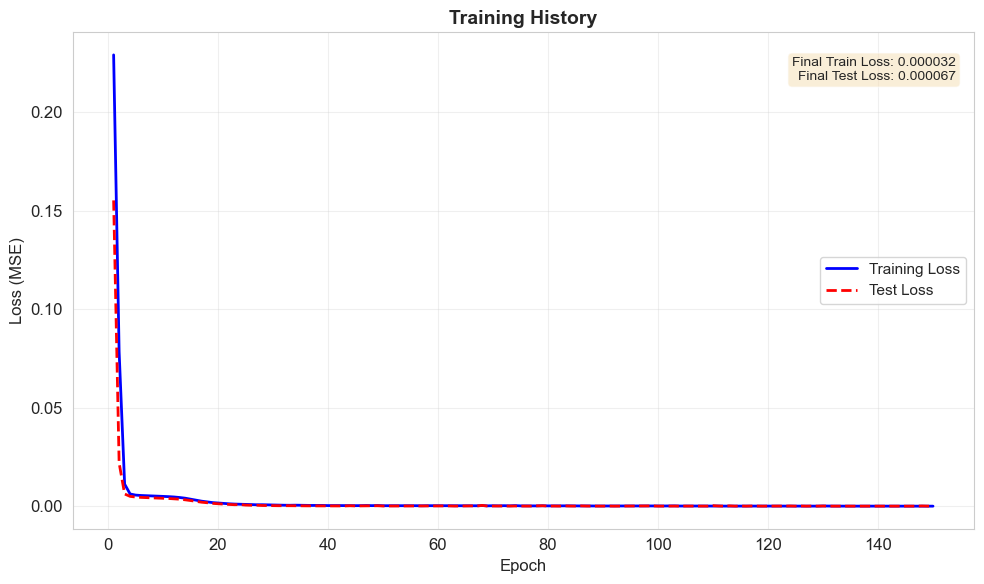

In [25]:
# ===================================================================
# PART 9: VISUALIZE TRAINING PROGRESS
# ===================================================================

def plot_training_history(train_losses, test_losses):
    """
    Plot training and test loss curves.
    
    What to look for:
    ----------------
    - Both losses should decrease over time
    - Training loss should be slightly lower than test loss
    - If test loss >> training loss: Overfitting
    - If both losses plateau: Model has converged
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    epochs = range(1, len(train_losses) + 1)
    
    ax.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax.plot(epochs, test_losses, 'r--', label='Test Loss', linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss (MSE)', fontsize=12)
    ax.set_title('Training History', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Annotate final losses
    final_train = train_losses[-1]
    final_test = test_losses[-1]
    ax.text(0.98, 0.95, 
            f'Final Train Loss: {final_train:.6f}\nFinal Test Loss: {final_test:.6f}',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

fig_history = plot_training_history(train_losses, test_losses)
plt.show()

In [26]:
# ===================================================================
# PART 10: EVALUATE MODEL PERFORMANCE
# ===================================================================

def evaluate_model(model, test_loader, device='cpu'):
    """
    Comprehensive evaluation of trained model.
    
    Metrics:
    -------
    1. MSE (Mean Squared Error): Average squared difference
    2. RMSE (Root MSE): Same units as target (easier to interpret)
    3. MAE (Mean Absolute Error): Average absolute difference
    4. R² Score: Proportion of variance explained (1.0 = perfect)
    
    Returns:
    --------
    predictions : np.ndarray
        Predicted probabilities
    targets : np.ndarray
        True probabilities
    metrics : dict
        Evaluation metrics
    """
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            
            predictions = model(batch_X)
            
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(batch_y.numpy())
    
    # Concatenate all batches
    predictions = np.vstack(all_predictions).flatten()
    targets = np.vstack(all_targets).flatten()
    
    # Compute metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    print("\n" + "="*70)
    print("MODEL EVALUATION ON TEST SET")
    print("="*70)
    for metric_name, value in metrics.items():
        print(f"{metric_name:10s}: {value:.6f}")
    print("="*70)
    
    return predictions, targets, metrics

# Evaluate model
predictions, targets, metrics = evaluate_model(model, test_loader, device=device)


MODEL EVALUATION ON TEST SET
MSE       : 0.000075
RMSE      : 0.008634
MAE       : 0.002804
R²        : 0.982784


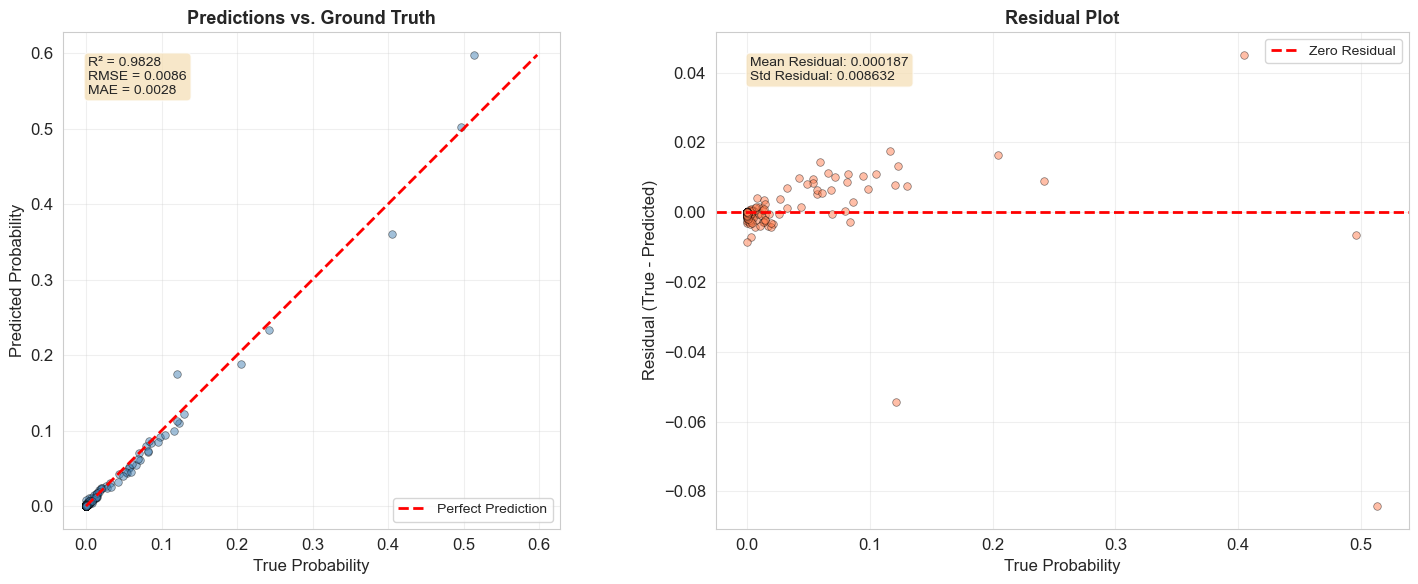

In [27]:
# ===================================================================
# PART 11: VISUALIZATION OF PREDICTIONS
# ===================================================================

def plot_predictions_vs_truth(predictions, targets, metrics):
    """
    Visualize model predictions against ground truth.
    
    Creates two plots:
    1. Scatter plot: Predictions vs. True Values
       - Points on diagonal line = perfect predictions
       - Spread shows prediction uncertainty
       
    2. Residual plot: (True - Predicted) vs. True Values
       - Should be randomly scattered around zero
       - Patterns indicate systematic bias
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # --- Plot 1: Predictions vs. Truth ---
    ax1 = axes[0]
    
    # Scatter plot
    ax1.scatter(targets, predictions, alpha=0.5, s=30, color='steelblue', 
                edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line (y=x)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 
             'r--', linewidth=2, label='Perfect Prediction')
    
    ax1.set_xlabel('True Probability', fontsize=12)
    ax1.set_ylabel('Predicted Probability', fontsize=12)
    ax1.set_title('Predictions vs. Ground Truth', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # Add metrics text
    metrics_text = f"R² = {metrics['R²']:.4f}\nRMSE = {metrics['RMSE']:.4f}\nMAE = {metrics['MAE']:.4f}"
    ax1.text(0.05, 0.95, metrics_text, transform=ax1.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # --- Plot 2: Residuals ---
    ax2 = axes[1]
    
    residuals = targets - predictions
    
    ax2.scatter(targets, residuals, alpha=0.5, s=30, color='coral',
                edgecolors='black', linewidth=0.5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    
    ax2.set_xlabel('True Probability', fontsize=12)
    ax2.set_ylabel('Residual (True - Predicted)', fontsize=12)
    ax2.set_title('Residual Plot', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Add statistics
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    ax2.text(0.05, 0.95, f"Mean Residual: {mean_residual:.6f}\nStd Residual: {std_residual:.6f}",
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    return fig

fig_pred = plot_predictions_vs_truth(predictions, targets, metrics)
plt.show()

In [28]:
# ===================================================================
# PART 12: SAVE TRAINED MODEL
# ===================================================================

def save_model(model, filepath='crosslink_nn_model.pth', save_full=True):
    """
    Save trained model to disk.
    
    Two options:
    1. Save only weights (state_dict) - recommended
    2. Save entire model - less flexible
    
    To load later:
    model = CrosslinkProbabilityNN(...)
    model.load_state_dict(torch.load('model.pth'))
    model.eval()
    """
    if save_full:
        # Save entire model
        torch.save(model, filepath)
        print(f"Saved complete model to {filepath}")
    else:
        # Save only state dictionary (recommended)
        torch.save(model.state_dict(), filepath)
        print(f"Saved model weights to {filepath}")
    
    # Also save model architecture info
    model_info = {
        'input_size': model.input_size,
        'hidden_sizes': model.hidden_sizes,
        'num_parameters': model.count_parameters()
    }
    
    info_filepath = filepath.replace('.pth', '_info.pkl')
    with open(info_filepath, 'wb') as f:
        pickle.dump(model_info, f)
    print(f"Saved model info to {info_filepath}")

# Save the trained model
save_model(model, filepath='crosslink_nn_model.pth', save_full=False)

Saved model weights to crosslink_nn_model.pth
Saved model info to crosslink_nn_model_info.pkl


In [29]:
# ===================================================================
# PART 13: INFERENCE FUNCTION (USING TRAINED MODEL)
# ===================================================================

def predict_crosslink_probability(model, scaler, d, sigma1, sigma2, L, device='cpu'):
    """
    Use trained model to predict crosslink probability for new data.
    
    Steps:
    1. Create feature vector [d, σ₁, σ₂, L]
    2. Normalize using saved scaler
    3. Convert to tensor
    4. Run through model
    5. Return probability
    
    Parameters:
    -----------
    model : nn.Module
        Trained neural network
    scaler : StandardScaler
        Fitted scaler from training
    d : float
        Distance between particles (Å)
    sigma1 : float
        Uncertainty of particle 1 (Å)
    sigma2 : float
        Uncertainty of particle 2 (Å)
    L : float
        Crosslinker length (Å)
    device : str
        'cpu' or 'cuda'
        
    Returns:
    --------
    probability : float
        Predicted crosslink probability (0-1)
    """
    model.eval()
    
    # Create feature vector
    features = np.array([[d, sigma1, sigma2, L]])
    
    # Normalize
    features_scaled = scaler.transform(features)
    
    # Convert to tensor
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    
    # Predict
    with torch.no_grad():
        probability = model(features_tensor).item()
    
    return probability

# Example prediction
example_d = 15.0
example_sigma1 = 5.0
example_sigma2 = 5.0
example_L = 21.0

pred_prob = predict_crosslink_probability(
    model, scaler, example_d, example_sigma1, example_sigma2, example_L, device=device
)

print(f"\n" + "="*70)
print("EXAMPLE PREDICTION")
print("="*70)
print(f"Input:")
print(f"  Distance (d): {example_d} Å")
print(f"  Sigma 1 (σ₁): {example_sigma1} Å")
print(f"  Sigma 2 (σ₂): {example_sigma2} Å")
print(f"  Linker Length (L): {example_L} Å")
print(f"\nPredicted Crosslink Probability: {pred_prob:.4f}")
print("="*70)


EXAMPLE PREDICTION
Input:
  Distance (d): 15.0 Å
  Sigma 1 (σ₁): 5.0 Å
  Sigma 2 (σ₂): 5.0 Å
  Linker Length (L): 21.0 Å

Predicted Crosslink Probability: 0.7199


In [30]:
# ===================================================================
# PART 14: SAVE ALL OUTPUTS
# ===================================================================

# Create output directory
output_dir = 'nn_output'
os.makedirs(output_dir, exist_ok=True)

# Save figures
fig_dist.savefig(os.path.join(output_dir, 'data_distribution.pdf'), dpi=300, bbox_inches='tight')
fig_corr.savefig(os.path.join(output_dir, 'correlation_matrix.pdf'), dpi=300, bbox_inches='tight')
fig_history.savefig(os.path.join(output_dir, 'training_history.pdf'), dpi=300, bbox_inches='tight')
fig_pred.savefig(os.path.join(output_dir, 'predictions.pdf'), dpi=300, bbox_inches='tight')

# Save metrics
with open(os.path.join(output_dir, 'evaluation_metrics.txt'), 'w') as f:
    f.write("MODEL EVALUATION METRICS\n")
    f.write("="*50 + "\n")
    for metric_name, value in metrics.items():
        f.write(f"{metric_name:10s}: {value:.6f}\n")
    f.write("\nMODEL ARCHITECTURE\n")
    f.write("="*50 + "\n")
    f.write(str(model))
    f.write(f"\n\nTotal Parameters: {model.count_parameters():,}\n")

print(f"\nAll outputs saved to {output_dir}/")
print("\nFiles created:")
print("  - data_distribution.pdf")
print("  - correlation_matrix.pdf")
print("  - training_history.pdf")
print("  - predictions.pdf")
print("  - evaluation_metrics.txt")
print("  - crosslink_nn_model.pth")
print("  - nn_scaler.pkl")

/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/2347958004.py:10: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig_dist.savefig(os.path.join(output_dir, 'data_distribution.pdf'), dpi=300, bbox_inches='tight')
/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/2347958004.py:10: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig_dist.savefig(os.path.join(output_dir, 'data_distribution.pdf'), dpi=300, bbox_inches='tight')
/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/2347958004.py:11: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig_corr.savefig(os.path.join(output_dir, 'correlation_matrix.pdf'), dpi=300, bbox_inches='tight')
/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_3606/2347958004.py:11: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig_corr.savefig(os.path.join(output_dir, 'correlation_matrix.pdf'), dpi=300, bbo


All outputs saved to nn_output/

Files created:
  - data_distribution.pdf
  - correlation_matrix.pdf
  - training_history.pdf
  - predictions.pdf
  - evaluation_metrics.txt
  - crosslink_nn_model.pth
  - nn_scaler.pkl
